In [165]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

In [166]:
#to do
###newdfclean
#Other data to get, public transportation, income by,  crime by 
#categorial: boro, tax code by class, zip-code,
# data= data[data['TAX_CLASS_AT_TIME_OF_SALE'] == 1 or 2]


In [172]:
data=pd.read_excel("rollingsales_manhattan.xls", skiprows=1) #combined excel sheets for 2016-2018

data = data[data['SALE_PRICE'] > 100] #get rid of 0's in sale price 
data=data[data['GROSS SQUARE FEET'] > 100] #get rid of 0s in square foot
data.columns=['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE']

In [200]:
# average_by_zip=pd.read_excel("Zip_MedianListingPrice_AllHomes.xls")
# average_by_zip_2018=average_by_zip.loc[:,["RegionName","2018-10"]] 
# average_by_zip_2018['ZIP_CODE']=average_by_zip_2018['RegionName']
# zillow_squarefootage['Zillowmedianlistprice']=zillow_squarefootage['2018-10']

zillow_squarefootage=pd.read_excel("Zip_MedianListingPricePerSqft_AllHomes.xls")
zillow_squarefootage=zillow_squarefootage.loc[:,["RegionName","2018-10"]] 
zillow_squarefootage['ZIP_CODE']=zillow_squarefootage['RegionName']
zillow_squarefootage['ZillowSquareFootage']=zillow_squarefootage['2018-10']

zillow_median_listing=pd.read_excel("Zip_MedianListingPrice_AllHomes.xls")
zillow_median_listing=zillow_median_listing.loc[:,["RegionName","2018-10"]] 
zillow_median_listing['ZIP_CODE']=zillow_median_listing['RegionName']
zillow_median_listing['ZillowMedianPrice']=zillow_median_listing['2018-10']

In [201]:
new_df2= zillow_squarefootage.merge(zillow_median_listing, how = 'inner', on = ['ZIP_CODE'])
# new_df3=new_df2.merge(average_by_zip_2018, how = 'inner', on = ['ZIP_CODE'])
new_df3= data.merge(new_df2, how = 'inner', on = ['ZIP_CODE'])
new_df=new_df3.copy()
new_df
new_df=new_df.drop(columns=['RegionName_y', 'RegionName_x',"2018-10_x","2018-10_y"])
# new_df

# [:,'BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
#        'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
#        'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
#        'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
#        'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
#        'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
#        'SALE_PRICE', 'SALE_DATE','Zillowsquarefootagezillow','zillowMedianPrice']

In [202]:
new_df['ZillowMedianPrice'] = new_df['ZillowMedianPrice'].astype(int)
new_df['ZillowSquareFootage'] = new_df['ZillowSquareFootage'].astype(int)

In [208]:
features= new_df[[
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       "ZillowSquareFootage","ZillowMedianPrice"]].copy()

In [41]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

In [ ]:
#create dummy variable to deal with categories... can make dummies 


#NExt test train split  Example
# create training and testing vars
# X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=34,test_size=0.2)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)


## fit a model
# lm = linear_model.LinearRegression()
# model = lm.fit(X_train, y_train)
# y_pred = lm.predict(X_test)

# ## The line / model
# plt.scatter(y_test, y_pred)
# plt.xlabel("True Values")
# plt.ylabel("Predictions")

##Print R Squared score
# print ("Score:", model.score(X_test, y_test))
##Score: 0.5496539094948476

##average of metrics 
# print(metrics.mean_absolute_error(y_test, y_pred))
# print(metrics.mean_squared_error(y_test, y_pred))
# print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

model.score()



In [ ]:
for column in features:
    data[column].plot.hist(density=True, label = column+' histogram')
    data[column].plot.kde(label =column+' kde')
    plt.legend()
    plt.show()

In [ ]:
dummy_df = pd.get_dummies(data,drop_first=True)
dummy_df.info()

In [130]:
# import seaborn as sns
# import statsmodels.api as sm
# import pylab
# sns.pairplot(data)[]

In [57]:
# data.info()
# data.dropna()
# data['SALE_PRICE'] = data['SALE_PRICE']
# carl=data['SALE_PRICE']
# # data['SALE_PRICE']
# # data
# data = data.drop(0,axis=0)
# data['GROSS SQUARE FEET'] > 0]   #830 entries
# data[data['LAND SQUARE FEET'] > 0] # 863 entries 
# data.columns

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
plt.style.use('fivethirtyeight')

data = data
f = 'SALE_PRICE~GROSS_SQUARE_FEET'
f2='SALE_PRICE~NEIGHBORHOOD'
f3='SALE_PRICE~LAND_SQUARE_FEET'
f4='SALE_PRICE~YEAR_BUILT'
f5= 'SALE_PRICE~ZIP_CODE'
model = smf.ols(formula=f, data=data).fit()
model2 = smf.ols(formula=f2, data=data).fit()
model3 = smf.ols(formula=f3, data=data).fit()
model4 = smf.ols(formula=f4, data=data).fit()
model5 = smf.ols(formula=f5, data=data).fit()
# model.summary()
# model.params
# model.pvalues
# model.rsquared

In [52]:
#look at each distribtions, graph them all 

/Users/powersky/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


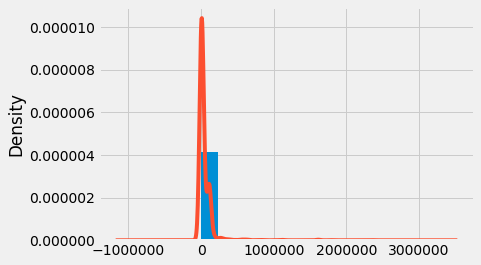

In [210]:
# data.plot.kde()
# plt.title("Normality check")
# plt.show()
# fig = plt.figure(figsize=(15,8))
# fig = sm.graphics.plot_regress_exog(model, "GROSS_SQUARE_FEET", fig=fig)
# plt.show()
data['GROSS_SQUARE_FEET'].plot.hist(normed=True, label =' histogram')
data['GROSS_SQUARE_FEET'].plot.kde(label ='kde')
# plt.legend()
# plt.show()

/Users/powersky/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


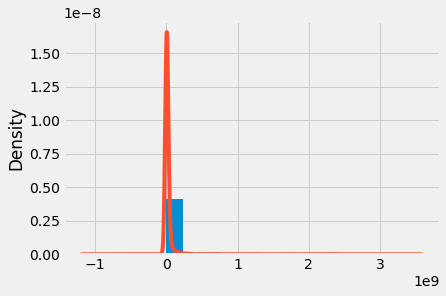

In [211]:
data['SALE_PRICE'].plot.hist(normed=True, label =' histogram')
data['SALE_PRICE'].plot.kde(label ='kde')
# plt.legend()
# plt.show()

/Users/powersky/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


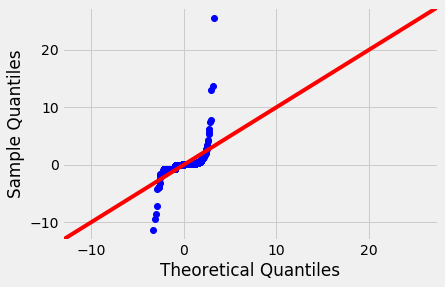

In [54]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE_PRICE   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     1776.
Date:                Wed, 05 Dec 2018   Prob (F-statistic):          1.33e-282
Time:                        11:45:02   Log-Likelihood:                -41492.
No. Observations:                2127   AIC:                         8.299e+04
Df Residuals:                    2125   BIC:                         8.300e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -3.03e+06   1.66e+06     -1.824      0.068   -6.29e+06    2.28e+05
GROSS_SQUARE_FEET   514.9126     12.219     42.141      0.000     490.950     538.875
==============================================================================
Omnibus:                     3328.490   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5502628.184
Skew:                           9.189   Prob(JB):                         0.00
Kurtosis:                     251.498   Cond. No.                     1.45e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [124]:
model.summary() #y variale is 799.36

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE_PRICE   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     926.0
Date:                Tue, 04 Dec 2018   Prob (F-statistic):          3.99e-136
Time:                        14:00:23   Log-Likelihood:                -15859.
No. Observations:                 810   AIC:                         3.172e+04
Df Residuals:                     808   BIC:                         3.173e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           1.81e+06   2.83e+06      0.640      0.523   -3.74e+06    7.37e+06
GROSS_SQUARE_FEET   799.3652     26.269     30.431      0.000     747.803     850.928
==============================================================================
Omnibus:                     1328.003   Durbin-Watson:                   0.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1723352.626
Skew:                           9.571   Prob(JB):                         0.00
Kurtosis:                     228.157   Cond. No.                     1.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

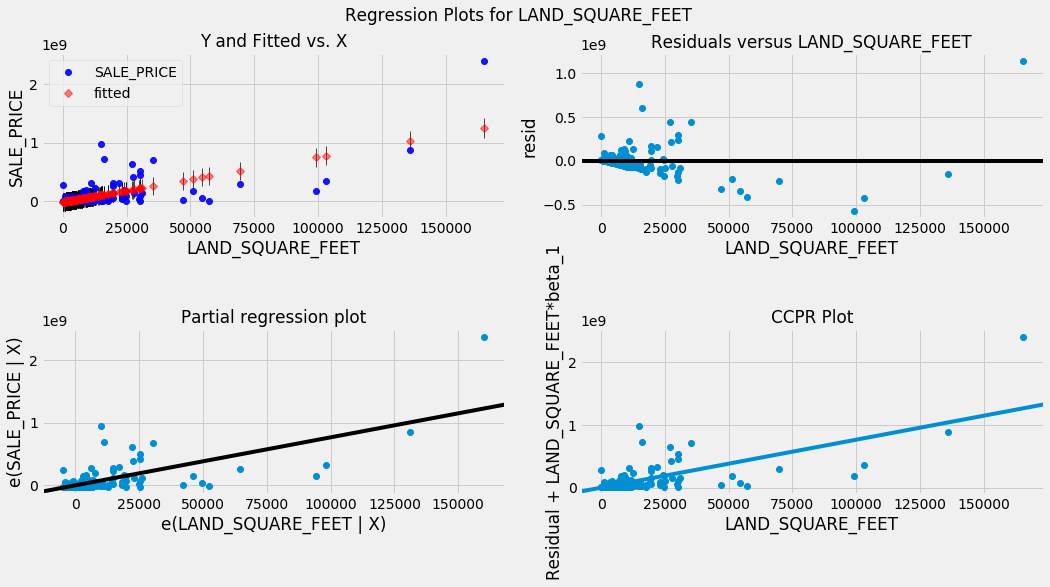

/Users/powersky/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


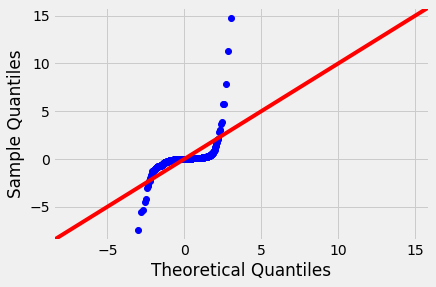

In [99]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model3, "LAND_SQUARE_FEET", fig=fig)
plt.show()
import scipy.stats as stats
residuals = model3.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [91]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE_PRICE   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     21.15
Date:                Tue, 04 Dec 2018   Prob (F-statistic):           4.93e-06
Time:                        10:10:55   Log-Likelihood:                -16157.
No. Observations:                 810   AIC:                         3.232e+04
Df Residuals:                     808   BIC:                         3.233e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.244e+09   2.76e+08     -4.502      0.000   -1.79e+09   -7.02e+08
YEAR_BUILT  6.623e+05   1.44e+05      4.599      0.000     3.8e+05    9.45e+05
==============================================================================
Omnibus:                     1589.139   Durbin-Watson:                   0.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2472827.033
Skew:                          14.273   Prob(JB):                         0.00
Kurtosis:                     272.173   Cond. No.                     1.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE_PRICE   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.645
Date:                Tue, 04 Dec 2018   Prob (F-statistic):              0.200
Time:                        10:10:55   Log-Likelihood:                -16167.
No. Observations:                 810   AIC:                         3.234e+04
Df Residuals:                     808   BIC:                         3.235e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.192e+09   9.09e+08      1.312      0.190   -5.92e+08    2.98e+09
ZIP_CODE   -1.162e+05   9.06e+04     -1.283      0.200   -2.94e+05    6.16e+04
==============================================================================
Omnibus:                     1565.981   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2196062.136
Skew:                          13.853   Prob(JB):                         0.00
Kurtosis:                     256.576   Cond. No.                     2.30e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [216]:
# #first we need to import some libraries
# import pylab
# import pandas as pd
# # import pandas.io.data as web
# import datetime
# %matplotlib inline
# import matplotlib.pyplot as plt
# from matplotlib import style
# import numpy as np

# import quandl
# #ZILLOW/{AREA_CATEGORY}{AREA_CODE}_{INDICATOR_CODE}
# #ZILLOW/C1_ZRISFRR

In [215]:
# quandl.ApiConfig.api_key = 'DoG1Rex2WTP5SQt6mchR'
# # quandl.get('ZILLOW/C25709_ZRISFRR', start_date='2018-10-31', end_date='2018-10-31')
# quandl.get('ZILLOW/C1_IMP')

# quandl.get('ZILLOW/C1_ZRISFRR', start_date='2018-10-31', end_date='2018-10-31')

In [ ]:
#quandl tries below can delete later

In [214]:
# quandl.ApiConfig.api_key = 'DoG1Rex2WTP5SQt6mchR'
# quandl.get('ZILLOW/C1_IMP', start_date='2018-08-31', end_date='2018-10-31')

In [213]:
# quandl.ApiConfig.api_key = 'DoG1Rex2WTP5SQt6mchR'
# quandl.get('ZILLOW/C1_IMP')

In [212]:
# quandl.ApiConfig.api_key = 'DoG1Rex2WTP5SQt6mchR'
# quandl.get('ZILLOW/C1_IMP')